<a href="https://colab.research.google.com/github/tarun-bisht/gray2color/blob/master/gray2color.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting google drive to save trained model


In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


# Importing all Dependencies

In [0]:
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from skimage.color import rgb2lab, lab2rgb, rgb2gray

# Downloading training dataset using curl

I found a alternative [kaggle dataset](https://www.kaggle.com/greatgamedota/ffhq-face-data-set) paste download link of dataset here. These link get obselete very soon so paste new download link.
Link can be get when you download it into local and in download section of browser you can get link for download. 
Size: Approx 2GB

In [12]:
!curl -o "/content/faces.zip" "https://storage.googleapis.com/kaggle-data-sets/379454/735991/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1590056491&Signature=iZbEXd9tLS6urEio8l4sGXEPbUdBOvwoyvqweIq%2BSEprSrQYGQ6AwS3Us93g%2FsV7OHMXI2dtXl0ZILOnA95nAjZv2u9DbCEjjsmqdZU3zuGXQpthruhAJ2ybVyFIBeTCuQdx1%2FoPHp3K%2FUSz03SODoeJG6zTg1QOEcp2vfIytplNIYIEVbHYuzokWN2ahDfW4JOQsytO%2F8TTJxB7fn2Yu16STvEf%2FKSpM7zHqvWqNyhh7d3hPgBIc1M6hZUHUXXWXT5PkJWeSa3gXSysvCOhemVWJyfhqX0tDs%2FM4MUtg1ZMe0V80KdzXrueBnIr5aVzuRn1PDFQvzANmGAkj1hrrQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dffhq-face-data-set.zip"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2015M  100 2015M    0     0  68.3M      0  0:00:29  0:00:29 --:--:-- 65.5M


# Unzipping the dataset

In [13]:
!mkdir "/content/faces"
!unzip "/content/faces.zip" -d "/content/faces"
!rm faces.zip

Streaming output truncated to the last 5000 lines.
  inflating: /content/faces/thumbnails128x128/65001.png  
  inflating: /content/faces/thumbnails128x128/65002.png  
  inflating: /content/faces/thumbnails128x128/65003.png  
  inflating: /content/faces/thumbnails128x128/65004.png  
  inflating: /content/faces/thumbnails128x128/65005.png  
  inflating: /content/faces/thumbnails128x128/65006.png  
  inflating: /content/faces/thumbnails128x128/65007.png  
  inflating: /content/faces/thumbnails128x128/65008.png  
  inflating: /content/faces/thumbnails128x128/65009.png  
  inflating: /content/faces/thumbnails128x128/65010.png  
  inflating: /content/faces/thumbnails128x128/65011.png  
  inflating: /content/faces/thumbnails128x128/65012.png  
  inflating: /content/faces/thumbnails128x128/65013.png  
  inflating: /content/faces/thumbnails128x128/65014.png  
  inflating: /content/faces/thumbnails128x128/65015.png  
  inflating: /content/faces/thumbnails128x128/65016.png  
  inflating: /content

# Load Data utility function
As there are around 70k images and cannot fit on RAM so specify it according to your RAM size

In [0]:
PATH=os.path.join("faces/thumbnails128x128")

In [0]:
def load_data(path,upper_limit=20000,lower_limit=0):
    data=[]
    files=os.listdir(PATH)
    for file in files[lower_limit:upper_limit]:
        image=Image.open(os.path.join(path,file))
        image=np.array(image)
        image=image/255.0
        data.append(image)
    return np.array(data)

# Loading train and test images

In [0]:
colored_train=load_data(PATH,lower_limit=35000,upper_limit=40000)

In [0]:
colored_test=load_data(PATH,lower_limit=15000,upper_limit=18000)

In [18]:
print(colored_train.shape)
print(colored_test.shape)

(5000, 128, 128, 3)
(3000, 128, 128, 3)


# Converting RGB color space to Lab color space  

In [0]:
lab_train=rgb2lab(colored_train)
lab_test=rgb2lab(colored_test)

# First Channel for input image for network

In [0]:
input_train=lab_train[:,:,:,0]
input_test=lab_test[:,:,:,0]

# Reshaping grayscale image 
So that it have 4 dimensions to feed to convolutional neural network 

In [0]:
input_train=input_train.reshape(-1,128,128,1)
input_test=input_test.reshape(-1,128,128,1)

# Remaining 2 Channel for output for network

In [0]:
output_train=lab_train[:,:,:,1:]
output_test=lab_test[:,:,:,1:]
output_train=output_train/128.0 # feature scaling
output_test=output_test/128.0

In [23]:
print(output_train.shape)
print(input_train.shape)
print(output_test.shape)
print(input_test.shape)

(5000, 128, 128, 2)
(5000, 128, 128, 1)
(3000, 128, 128, 2)
(3000, 128, 128, 1)


# Utility Functions 
1. merge_channels: merge the L channel (input) with ab channel (output)
2. decoded_images: do merge_channels for all decoder output image
3. plot_images: plot images using numpy

In [0]:
def merge_channels(input_L,output_ab):
    image=np.zeros(shape=(input_L.shape[0],input_L.shape[1],3))
    image[:,:,0]=np.squeeze(input_L)
    image[:,:,1:]=output_ab
    return image

In [0]:
def decoded_images(encoded_input,decoded_output):
    assert len(encoded_input)==len(decoded_output)
    images=[]
    for i in range(len(encoded_input)):
        img=merge_channels(encoded_input[i],decoded_output[i]*128.0)
        img=lab2rgb(img)
        images.append(img)
    return np.array(images)

In [0]:
def plot_images(images,w=3,h=3,cmap=None):
    images=np.squeeze(images)
    fig, axes = plt.subplots(w, h)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        if cmap is not None:
            ax.imshow(images[i],cmap=cmap)
        else:
            ax.imshow(images[i])
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

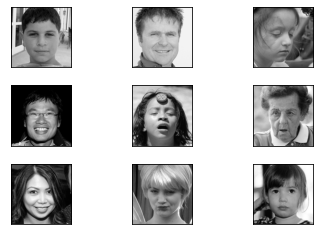

In [27]:
images=input_train[0:9]
plot_images(images,cmap="gray",w=3,h=3)

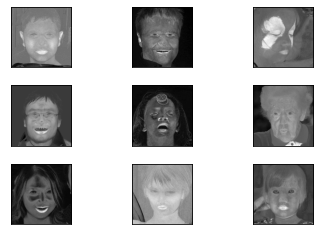

In [28]:
images=output_train[0:9][:,:,:,0]
plot_images(images,cmap="gray",w=3,h=3)

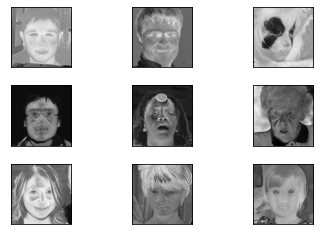

In [29]:
images=output_train[0:9][:,:,:,1]
plot_images(images,cmap="gray",w=3,h=3)

Lets test how our merge_channels function works

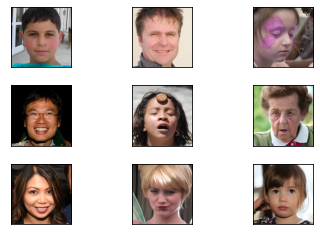

In [31]:
images=decoded_images(input_train[0:9],output_train[0:9])
plot_images(images,w=3,h=3)

# Encoder and Decoder creation
our encoder and decoder consists of convolutional and convolution transpose layers

In [0]:
bottleneck_unit=8

In [0]:
inputs=keras.layers.Input(shape=(128,128,1),name="input")
enc=keras.layers.Conv2D(filters=512,kernel_size=(3,3),strides=2,padding="same",activation="relu",name="encoder1")(inputs)
enc=keras.layers.Conv2D(filters=256,kernel_size=(3,3),strides=1,padding="same",activation="relu",name="encoder2")(enc)
enc=keras.layers.Conv2D(filters=128,kernel_size=(3,3),strides=1,padding="same",activation="relu",name="encoder3")(enc)
enc=keras.layers.Conv2D(filters=64,kernel_size=(3,3),strides=2,padding="same",activation="relu",name="encoder4")(enc)
enc=keras.layers.Conv2D(filters=32,kernel_size=(3,3),strides=1,padding="same",activation="relu",name="encoder5")(enc)
enc=keras.layers.Conv2D(filters=16,kernel_size=(3,3),strides=2,padding="same",activation="relu",name="encoder6")(enc)

In [0]:
bottleneck=keras.layers.Conv2D(filters=bottleneck_unit,kernel_size=(3,3),strides=2,padding="same",activation="relu",name="bottleneck")(enc)

# check if we have trained model on our gdrive to further tuning

In [35]:
if os.path.isfile(os.path.join("..","gdrive","My Drive","gray2color","encoder.h5")):
    encoder=keras.models.load_model(os.path.join("..","gdrive","My Drive","gray2color","encoder.h5"),compile=True)
    print("resuming older model")
else:
    encoder=keras.Model(inputs=inputs,outputs=bottleneck)
    print("No precious model found")

resuming older model


In [36]:
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
encoder1 (Conv2D)            (None, 64, 64, 512)       5120      
_________________________________________________________________
encoder2 (Conv2D)            (None, 64, 64, 256)       1179904   
_________________________________________________________________
encoder3 (Conv2D)            (None, 64, 64, 128)       295040    
_________________________________________________________________
encoder4 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
encoder5 (Conv2D)            (None, 32, 32, 32)        18464     
_________________________________________________________________
encoder6 (Conv2D)            (None, 16, 16, 16)        4624  

In [0]:
encoded_input=keras.layers.Input(shape=(8,8,bottleneck_unit))
dec=keras.layers.Conv2DTranspose(filters=16,strides=2,kernel_size=(3,3),padding="same",activation="relu",name="decoder1")(encoded_input)
dec=keras.layers.Conv2DTranspose(filters=32,strides=1,kernel_size=(3,3),padding="same",activation="relu",name="decoder2")(dec)
dec=keras.layers.Conv2DTranspose(filters=64,strides=2,kernel_size=(3,3),padding="same",activation="relu",name="decoder3")(dec)
dec=keras.layers.Conv2DTranspose(filters=128,strides=1,kernel_size=(3,3),padding="same",activation="relu",name="decoder4")(dec)
dec=keras.layers.Conv2DTranspose(filters=256,strides=1,kernel_size=(3,3),padding="same",activation="relu",name="decoder5")(dec)
dec=keras.layers.Conv2DTranspose(filters=512,strides=2,kernel_size=(3,3),padding="same",activation="relu",name="decoder6")(dec)
outputs=keras.layers.Conv2DTranspose(filters=2,strides=2,kernel_size=(3,3),padding="same",activation="tanh",name="output")(dec)

In [38]:
if os.path.isfile(os.path.join("..","gdrive","My Drive","gray2color","decoder.h5")):
    decoder=keras.models.load_model(os.path.join("..","gdrive","My Drive","gray2color","decoder.h5"))
    print("resuming older model")
else:
    decoder=keras.Model(inputs=encoded_input,outputs=outputs)
    print("No precious model found")

resuming older model


In [39]:
decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8, 8, 8)]         0         
_________________________________________________________________
decoder1 (Conv2DTranspose)   (None, 16, 16, 16)        1168      
_________________________________________________________________
decoder2 (Conv2DTranspose)   (None, 16, 16, 32)        4640      
_________________________________________________________________
decoder3 (Conv2DTranspose)   (None, 32, 32, 64)        18496     
_________________________________________________________________
decoder4 (Conv2DTranspose)   (None, 32, 32, 128)       73856     
_________________________________________________________________
decoder5 (Conv2DTranspose)   (None, 32, 32, 256)       295168    
_________________________________________________________________
decoder6 (Conv2DTranspose)   (None, 64, 64, 512)       1180

# Creating our AutoEncoder model

In [0]:
class AutoEncoder(keras.Model):
    def __init__(self,encoder,decoder):
        super(AutoEncoder, self).__init__()
        self.encoder=encoder
        self.decoder=decoder
    def call(self,inputs):
        m=self.encoder.layers[0](inputs)
        for i in range(1,len(self.encoder.layers)):
            m=self.encoder.layers[i](m)
        for i in range(1,len(self.decoder.layers)):
            m=self.decoder.layers[i](m)
        return m

In [0]:
autoencoder=AutoEncoder(encoder,decoder)

In [0]:
autoencoder.compile(optimizer="adam",loss="mse")

In [0]:
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(
    monitor="loss",
    factor=0.1,
    patience=10,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0
)

# Training the model

In [44]:
epochs=10
history=autoencoder.fit(input_train,output_train,batch_size=32,epochs=epochs,shuffle=True,callbacks=[reduce_lr])

Epoch 1/10
157/157 [==============================] - 21s 134ms/step - loss: 0.0095 - lr: 0.0010
Epoch 2/10
157/157 [==============================] - 21s 131ms/step - loss: 0.0093 - lr: 0.0010
Epoch 3/10
157/157 [==============================] - 21s 131ms/step - loss: 0.0092 - lr: 0.0010
Epoch 4/10
157/157 [==============================] - 21s 131ms/step - loss: 0.0091 - lr: 0.0010
Epoch 5/10
157/157 [==============================] - 21s 131ms/step - loss: 0.0090 - lr: 0.0010
Epoch 6/10
157/157 [==============================] - 21s 131ms/step - loss: 0.0089 - lr: 0.0010
Epoch 7/10
157/157 [==============================] - 21s 131ms/step - loss: 0.0088 - lr: 0.0010
Epoch 8/10
157/157 [==============================] - 21s 131ms/step - loss: 0.0086 - lr: 0.0010
Epoch 9/10
157/157 [==============================] - 21s 131ms/step - loss: 0.0085 - lr: 0.0010
Epoch 10/10
157/157 [==============================] - 20s 130ms/step - loss: 0.0083 - lr: 0.0010


# Testing the model
1. latent vectors are spit out by encoder
2. these vectors are passes to decoder to generate colored images 

In [0]:
latent_vectors=encoder.predict(input_test)

In [0]:
decoded_test_images=decoder.predict(latent_vectors)

In [47]:
val_loss=keras.losses.mse(output_test,decoded_test_images)
print(tf.reduce_mean(val_loss).numpy())

0.009874075


# Plotting test output images and original test colored images

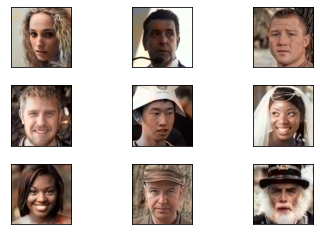

In [48]:
images=decoded_images(input_test[0:20],decoded_test_images[0:20])
plot_images(images)

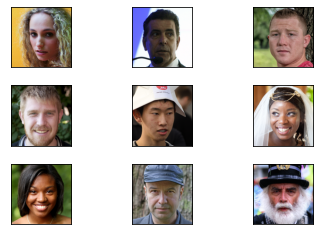

In [49]:
images=colored_test[0:20]
plot_images(images)

# Saving the model to local or gdrive

In [0]:
encoder.save("encoder.h5")
decoder.save("decoder.h5")

In [51]:
encoder.save("/gdrive/My Drive/gray2color/encoder.h5")
decoder.save("/gdrive/My Drive/gray2color/decoder.h5")
!ls '/gdrive/My Drive/'

'Colab Notebooks'		 dogs_classifier_mobilenetv2.h5
 Data				 gray2color
 datasets			 Images
 dogs_classifier_mobilenet1.h5	 Keystores
 dogs_classifier_mobilenet.h5	 tarun_bisht_coat11.jpg
